In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
import seaborn as sns
import os
import sys
from scipy.stats import wasserstein_distance
from datetime import datetime
from matplotlib.dates import DateFormatter
from tqdm import tqdm

sys.path.append('.')
sys.path.append('../')

from src.utils.data_prep import (combined_annotations,
                                create_matched_data,
                                create_max_windows,
                                create_summary_data,
                                create_data_splits,
                                setup_dataloaders,
                                give_balanced_weights)

from src.utils.io import (get_matched_data_path,
                          get_matched_metadata_path,
                          get_matched_summary_path,
                          get_metadata_path,
                          get_video_labels_path,
                          get_audio_labels_path,
                          get_figures_dir,
                          get_project_root,
                          get_results_dir,
                          )

from config.settings import (COLLAPSE_BEHAVIORS_MAPPING,
                            BEHAVIORS,
                             SAMPLING_RATE,
                             )

from src.utils.functionalities import (sliced_wasserstein_distance,
                                      ot_align,
                                      minmax_scale)
from config.paths import (HISTORIC_ACC)

In [2]:
# Graphing Parameters
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams["axes.labelsize"] = 22
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = True

## 1. Data Cleaning and Exploratory Data Analysis

In [3]:
files = [file for file in os.listdir(HISTORIC_ACC) if file.endswith('.txt')]

dfs = []
for file in files:
    df_temp = pd.read_table(os.path.join(HISTORIC_ACC, file))
    df_temp['dog'] = file.split('_')[0]
    df_temp = df_temp.sort_values(by='UTC time (yyyy-mm-dd HH:MM:SS)')
    dfs.append(df_temp)


df = pd.concat(dfs)
df['UTC time (yyyy-mm-dd HH:MM:SS)'] = pd.to_datetime(df['UTC time (yyyy-mm-dd HH:MM:SS)'])
df = df.rename(columns={'UTC time (yyyy-mm-dd HH:MM:SS)': 'UTC time', 
                        'GPS time (s)': 'GPS time', 
                        'Max accel peak X': 'Max peak X',
                        'Max accel peak Y': 'Max peak Y',
                        'Max accel peak Z': 'Max peak Z',
                        'Mean accel peak X': 'Mean peak X',
                        'Mean accel peak Y': 'Mean peak Y',
                        'Mean accel peak Z': 'Mean peak Z',
                        'Mean accel X': 'Mean X',
                        'Mean accel Y': 'Mean Y',
                        'Mean accel Z': 'Mean Z'
                        })
df.groupby('dog').agg({'UTC time': ['min', 'max']})


UTC time                        
                             min                     max
dog                                                     
Accra    1970-01-05 18:05:23.600 2012-08-30 15:17:09.200
Adiga    1970-01-02 08:03:14.600 2016-03-23 14:47:17.400
Aztec    1970-01-01 08:17:52.000 2014-10-01 08:02:26.400
Bali     2015-01-31 14:28:29.000 2016-03-05 08:27:23.800
Bobedi   1970-01-01 14:20:15.200 2012-06-22 09:55:19.800
Bongwe   1970-01-03 08:10:04.200 2016-02-06 13:53:22.600
Brian    1970-01-04 15:17:59.200 2012-05-31 08:46:32.000
Dar      2012-04-15 07:03:48.993 2012-05-05 08:01:25.200
Fiji     2016-03-23 13:43:54.800 2016-11-23 15:57:30.400
Gomer    1970-01-03 08:05:04.200 2012-09-07 20:59:04.831
Jesus    1970-01-03 03:07:34.800 2012-06-19 14:42:26.800
Kigali   1970-01-01 15:15:25.600 2012-08-30 15:16:52.800
Kobe     1970-01-02 09:41:29.200 2012-07-08 13:34:44.000
Kubu     1970-01-02 08:51:43.000 2012-07-06 08:11:35.200
Lupe     2014-07-30 11:36:15.000 2015-02-20 14:14:49.000
Mj       1970-01-06 15:36:54.800 2012-08-30 15:11:25.000
Pula     1970-01-05 13:50:45.000 2015-07-03 10:36:21.600
Scorpion 1970-01-05 14:53:45.400 2012-08-30 14:50:14.400
Stetson  2011-12-02 15:24:52.800 2012-03-29 15:14:56.995
Tangiers 2014-06-04 11:05:15.000 2015-10-13 15:25:43.400
Timbuktu 2012-04-19 08:36:55.000 2012-07-26 05:50:38.000
Xerxes   1970-01-02 20:56:43.000 2016-04-16 15:43:32.800
Yolo     1970-01-02 14:12:57.200 2012-08-20 22:38:18.000
Zulu     2015-08-08 11:21:00.200 2015-12-04 09:52:24.200

In [4]:
df['date'] = df['UTC time'].dt.date
df = df[df['UTC time'].dt.year > 2000]

# Check if there are any duplicate rows in the DataFrame
has_duplicates = df.duplicated().any()

if has_duplicates:
    print("The DataFrame contains duplicate rows.")
else:
    print("The DataFrame does not contain any duplicate rows.")

# To see how many duplicates there are:
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows found: {num_duplicates}")

The DataFrame contains duplicate rows.
Number of duplicate rows found: 72185


In [5]:
shape_before = df.shape
print(f"Shape before removing duplicates: {shape_before}")

# Remove duplicate rows
df.drop_duplicates(inplace=True) # inplace=False is default, returns a new df

shape_after = df.shape
print(f"Shape after removing duplicates: {shape_after}")

Shape before removing duplicates: (7246002, 17)
Shape after removing duplicates: (7173817, 17)


In [6]:
grouped_df = (
    df.groupby(['dog', 'date'])
      .agg(
          count=('dog', 'count'),  # count any column; 'dog' is used here
          Max_peak_X_min=('Max peak X', 'min'),
          Max_peak_X_max=('Max peak X', 'max'),
          Max_peak_Y_min=('Max peak Y', 'min'),
          Max_peak_Y_max=('Max peak Y', 'max'),
          Max_peak_Z_min=('Max peak Z', 'min'),
          Max_peak_Z_max=('Max peak Z', 'max'),
          Mean_peak_X_min=('Mean peak X', 'min'),
          Mean_peak_X_max=('Mean peak X', 'max'),
          Mean_peak_Y_min=('Mean peak Y', 'min'),
          Mean_peak_Y_max=('Mean peak Y', 'max'),
          Mean_peak_Z_min=('Mean peak Z', 'min'),
          Mean_peak_Z_max=('Mean peak Z', 'max'),
          Mean_X_min=('Mean X', 'min'),
          Mean_X_max=('Mean X', 'max'),
          Mean_Y_min=('Mean Y', 'min'),
          Mean_Y_max=('Mean Y', 'max'),
          Mean_Z_min=('Mean Z', 'min'),
          Mean_Z_max=('Mean Z', 'max'),
      )
      .reset_index()
)
grouped_df.sort_values(by='count', ascending=True, inplace=True)
grouped_df.to_csv("../results/historic_data_summary.csv", index=False)

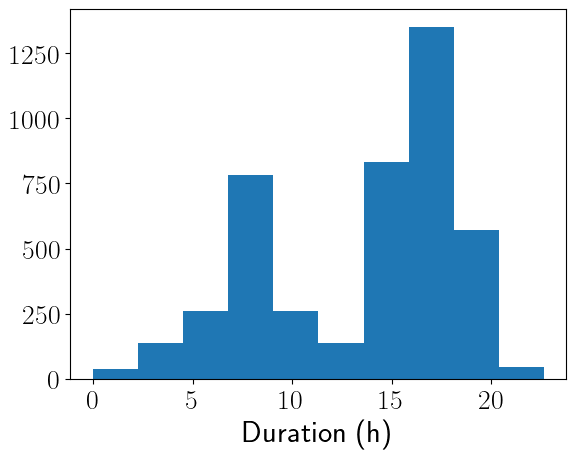

In [7]:
plt.hist(grouped_df['count']*30/3600)
plt.xlabel("Duration (h)")
plt.show()

In [8]:
feats = ['Max peak X','Max peak Y', 'Max peak Z', 
        'Mean peak X','Mean peak Y','Mean peak Z', 
        'Mean X', 'Mean Y', 'Mean Z']
def Tstat(x):
    return np.mean(x)/np.std(x)
def Q1(x):
    return x.quantile(0.25)
def Q3(x):
    return x.quantile(0.75)

df.groupby('dog')[feats].agg([Q1,
                              Q3, 
                              'min', 
                              'max'])

Max peak X                   Max peak Y                   Max peak Z  \
                 Q1     Q3 min    max         Q1     Q3 min    max         Q1   
dog                                                                             
Accra          20.0  306.0   2   2703       14.0  587.0   2   2748       10.0   
Adiga          14.0  455.0   0   4095       17.0  420.0   0   4095       12.0   
Aztec          31.0  483.0   2   2803       27.0  850.0   2   2778       19.0   
Bali           15.0  413.0   0   4095       18.0  313.0   0   4095       16.0   
Bobedi         22.0  323.0   2   2333       20.0  547.0   2  33224       15.0   
Bongwe         20.0  527.0   0  47912       26.0  461.0   0  20657       16.0   
Brian          20.0  351.0   2   2670       17.0  533.0   2   2733       13.0   
Dar            21.0  350.0   0  46434       34.0  560.0  27   2760       12.0   
Fiji           15.0  471.0   0   4095       21.0  481.0   0   4095       10.0   
Gomer          15.0  322.0   2  17248       11.0  534.0   2  49663        7.0   
Jesus          13.0  386.0   2   2703       10.0  717.0   2   2722        7.0   
Kigali         26.0  382.0   2   2685       22.0  862.0   2   2741       18.0   
Kobe            7.0  338.0   2   2650        6.0  543.0   2   2719        4.0   
Kubu           10.0  367.0   2   2311       10.0  816.0   2   2727        6.0   
Lupe           22.0  486.0   0   4095       26.0  441.0   0   4095       16.0   
Mj             26.0  248.0   2   2654       23.0  499.0   2   2729       16.0   
Pula           20.0  548.0   0   4095       24.0  469.0   0   4095       16.0   
Scorpion       19.0  332.0   2   2785       16.0  492.0   2  44659       11.0   
Stetson        16.0  239.0   2  59096       12.0  451.0   2   2771       10.0   
Tangiers       20.0  668.0   0   4095       26.0  471.0   0   4095       16.0   
Timbuktu       24.0  331.0   3   2606       22.0  415.0   2   2683       15.0   
Xerxes         18.0  448.0   0   4095       25.0  413.0   0   4095       16.0   
Yolo           21.0  280.0   0  44577       18.0  347.0   0  10529       15.0   
Zulu           16.0  474.0   0   4095       21.0  459.0   0   4095       16.0   

                 ... Mean X         Mean Y                        Mean Z  \
             Q3  ...    min    max      Q1      Q3    min    max      Q1   
dog              ...                                                       
Accra     416.0  ...      0   2239  2087.0  2140.0      0   2220  1936.0   
Adiga     400.0  ...   -250   2238     0.0   125.0   -428   3697  -219.0   
Aztec     571.0  ...      0   2236  2079.0  2119.0      0   2214  1940.0   
Bali      288.0  ...   -235   2927   -13.0    24.0  -2062   1060  -233.0   
Bobedi    433.0  ...      0   3954  2108.0  2168.0      0   5656  1955.0   
Bongwe    445.0  ... -19102  22304     0.0   114.0 -20959   3096  -215.0   
Brian     460.0  ...   1969   2227  2089.0  2142.0   1997   2214  1946.0   
Dar       436.0  ...  -3571   2199  2068.0  2129.0 -20959  19637  1943.0   
Fiji      395.0  ...   -243    251     0.0   142.0   -331    377  -185.0   
Gomer     390.0  ...      0  12042  2081.0  2128.0      0   4359  1950.0   
Jesus     474.0  ...   -100  22564  2101.0  2162.0 -19102  24637  1961.0   
Kigali    640.0  ... -29972   2611  2093.0  2154.0 -27232   2225  1956.0   
Kobe      375.0  ...      0   2245  2082.0  2138.0      0   2210  1974.0   
Kubu      539.0  ...   -129   5632  2076.0  2128.0 -20959  13444  1957.0   
Lupe      368.0  ...   -252    245     0.0    95.0   -314    400  -220.0   
Mj        375.0  ... -28416   2225  2080.0  2140.0      0   2211  1953.0   
Pula      464.0  ...   -239    250     0.0    95.0   -378    349  -214.0   
Scorpion  406.5  ...      0   2234  2095.0  2159.0      0   5120  1932.0   
Stetson   379.0  ...      0   2218  2099.0  2151.0      0   2228  1969.0   
Tangiers  544.0  ...   -252    252   -20.0     8.0   -383    514  -229.0   
Timbuktu  367.0  ...      0   2246  2084.0  2153.0      0   2216  1937.0 

In [9]:
df_summary = df.groupby('dog').agg({'date': ['min', 'max', 'count', 'nunique']})
df_summary.columns = ['Start date', 'End date', 'Total no. of windows', 'No. of unique dates']
df_summary

,Start date,End date,Total no. of windows,No. of unique dates
dog,,,,
Accra,2012-04-19,2012-08-30,17347,23
Adiga,2013-08-05,2016-03-23,1009065,595
Aztec,2014-02-25,2014-10-01,230405,219
Bali,2015-01-31,2016-03-05,717366,373
Bobedi,2011-12-04,2012-06-22,110523,126
Bongwe,2012-04-11,2016-02-06,480292,273
Brian,2012-04-02,2012-05-31,24410,27
Dar,2012-04-15,2012-05-05,17939,21
Fiji,2016-03-23,2016-11-23,463086,246


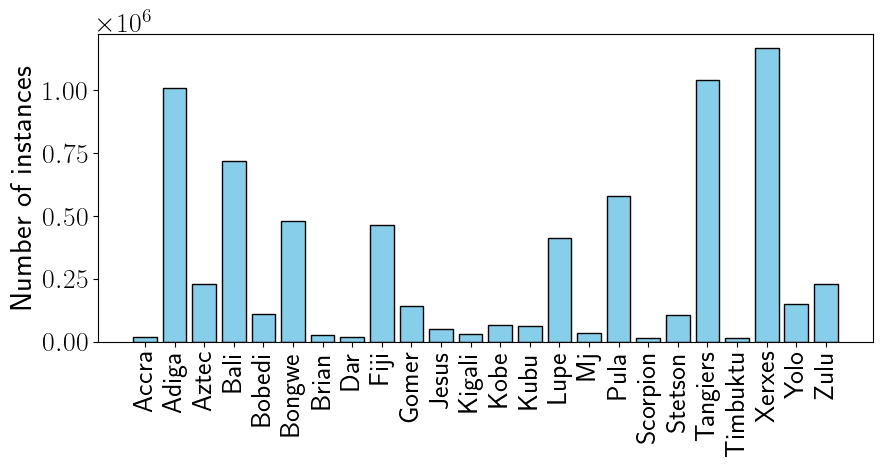

In [10]:
plt.figure(figsize = (10,4))
plt.bar(df_summary.index, df_summary['Total no. of windows'], color='skyblue', edgecolor='black')
plt.ylabel('Number of instances')
plt.xticks(rotation = 90)
plt.show()

Notice the presence of outliers for several dogs, especially Bongwe.

## 2. Outlier Detection


In [11]:
historic_data = df.copy()

threshold = 5000

for column in feats:
    # Keep only the data below this threshold
    historic_data = historic_data[(historic_data[column] <= threshold)]

print(f"\nOriginal shape: {df.shape}")
print(f"Shape after percentile outlier removal: {historic_data.shape}")



Original shape: (7173817, 17)
Shape after percentile outlier removal: (7173771, 17)


In [12]:
grouped_df = (
    historic_data.groupby(['dog', 'date'])
      .agg(
          count=('dog', 'count'),  # count any column; 'dog' is used here
          Max_peak_X_min=('Max peak X', 'min'),
          Max_peak_X_max=('Max peak X', 'max'),
          Max_peak_Y_min=('Max peak Y', 'min'),
          Max_peak_Y_max=('Max peak Y', 'max'),
          Max_peak_Z_min=('Max peak Z', 'min'),
          Max_peak_Z_max=('Max peak Z', 'max'),
          Mean_peak_X_min=('Mean peak X', 'min'),
          Mean_peak_X_max=('Mean peak X', 'max'),
          Mean_peak_Y_min=('Mean peak Y', 'min'),
          Mean_peak_Y_max=('Mean peak Y', 'max'),
          Mean_peak_Z_min=('Mean peak Z', 'min'),
          Mean_peak_Z_max=('Mean peak Z', 'max'),
          Mean_X_min=('Mean X', 'min'),
          Mean_X_max=('Mean X', 'max'),
          Mean_Y_min=('Mean Y', 'min'),
          Mean_Y_max=('Mean Y', 'max'),
          Mean_Z_min=('Mean Z', 'min'),
          Mean_Z_max=('Mean Z', 'max'),
      )
      .reset_index()
)
grouped_df.sort_values(by='count', ascending=True, inplace=True)
grouped_df.to_csv("../results/cleaned_historic_data_summary.csv", index=False)

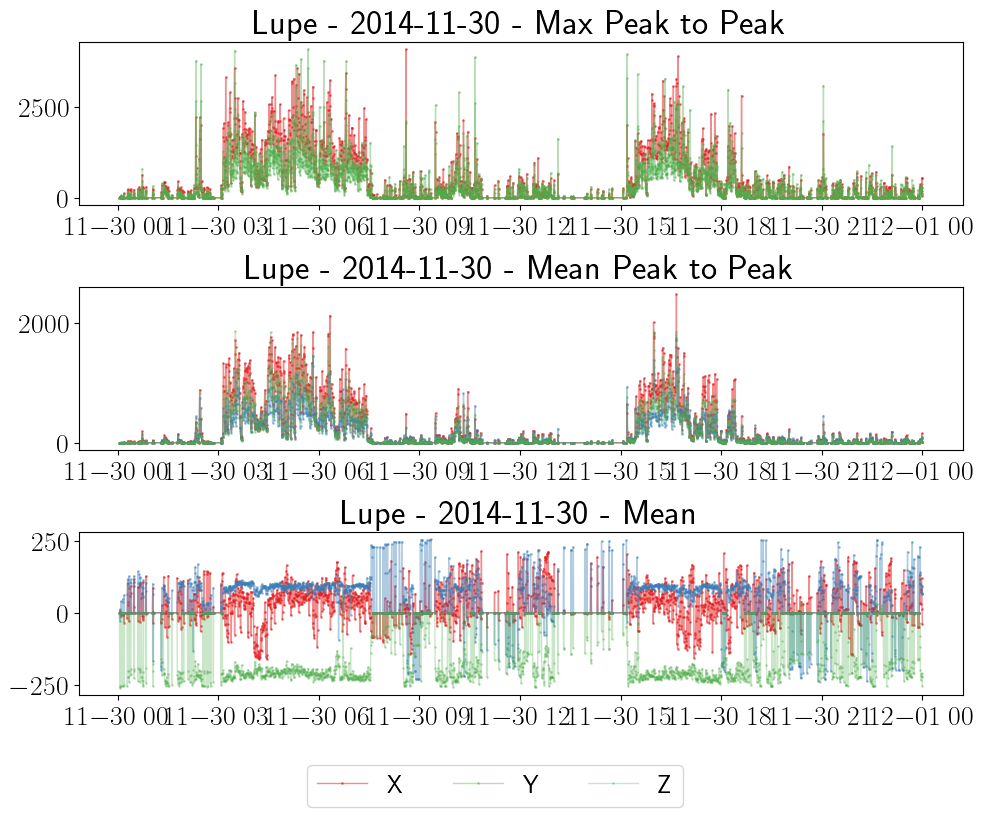

In [13]:
dogs = historic_data.dog.unique()
selected_dog = np.random.choice(dogs)
df_sub = historic_data[historic_data.dog == selected_dog]
dates = df_sub['UTC time'].dt.date.unique()
date = np.random.choice(dates)

palette = sns.color_palette("Set1", n_colors=3)

fig, axs = plt.subplots(3, 1, figsize=(10,7.5))

df_tmp = df_sub[df_sub['UTC time'].dt.date == date]
loc = AutoDateLocator()
form = AutoDateFormatter(loc)
axs[0].xaxis.set_major_locator(loc)
axs[0].xaxis.set_major_formatter(form)  
axs[0].plot(df_tmp['UTC time'], df_tmp['Max peak X'], marker='o', markersize=1, alpha=0.5, linestyle='-', color=palette[0], label='X')
axs[0].plot(df_tmp['UTC time'], df_tmp['Max peak Y'], marker='o', markersize=1, alpha=0.4, linestyle='-', color=palette[2], label='Y')
axs[0].plot(df_tmp['UTC time'], df_tmp['Max peak Z'], marker='o', markersize=1, alpha=0.3, linestyle='-', color=palette[2], label='Z')
axs[0].set_title(f'{selected_dog} - {str(date)} - Max Peak to Peak')
# axs[0].legend(loc='best')

axs[1].xaxis.set_major_locator(loc)
axs[1].xaxis.set_major_formatter(form)  
axs[1].plot(df_tmp['UTC time'], df_tmp['Mean peak X'], marker='o', markersize=1, alpha=0.5, linestyle='-', color=palette[0])
axs[1].plot(df_tmp['UTC time'], df_tmp['Mean peak Y'], marker='o', markersize=1, alpha=0.4, linestyle='-', color=palette[1])
axs[1].plot(df_tmp['UTC time'], df_tmp['Mean peak Z'], marker='o', markersize=1, alpha=0.3, linestyle='-', color=palette[2])
axs[1].set_title(f'{selected_dog} - {str(date)} - Mean Peak to Peak')
# axs[1].legend(loc='best')

axs[2].xaxis.set_major_locator(loc)
axs[2].xaxis.set_major_formatter(form)  
axs[2].plot(df_tmp['UTC time'], df_tmp['Mean X'], marker='o', markersize=1, alpha=0.5, linestyle='-', color=palette[0])
axs[2].plot(df_tmp['UTC time'], df_tmp['Mean Y'], marker='o', markersize=1, alpha=0.4, linestyle='-', color=palette[1])
axs[2].plot(df_tmp['UTC time'], df_tmp['Mean Z'], marker='o', markersize=1, alpha=0.3, linestyle='-', color=palette[2])
axs[2].set_title(f'{selected_dog} - {str(date)} - Mean')
# axs[2].legend(loc='best')

fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5,-0.1))
plt.tight_layout()
plt.show()

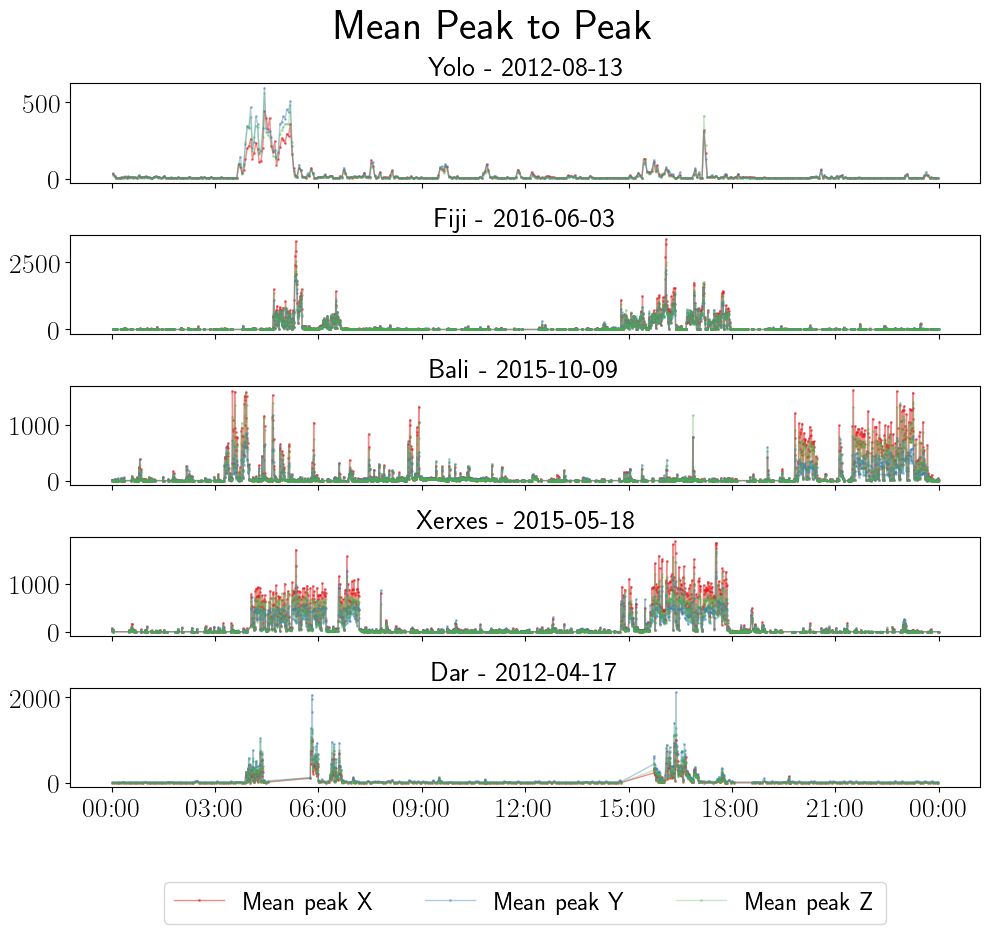

In [15]:
selected_dog_date = {'Yolo': '2012-08-13',
                     'Fiji': '2016-06-03',
                     'Bali': '2015-10-09',
                     'Xerxes': '2015-05-18',
                     'Dar': '2012-04-17'
                     }
fig, axs = plt.subplots(len(selected_dog_date), 1, figsize=(10,2*len(selected_dog_date)), sharex=True)
palette = sns.color_palette("Set1", n_colors=3)

for i, (dog, date) in enumerate(selected_dog_date.items()):
    date = datetime.strptime(date, "%Y-%m-%d").date()
    df_tmp = historic_data[(historic_data.dog == dog) & (historic_data['UTC time'].dt.date == date)].copy()
    
    # Replace the full datetime with a dummy date and actual time
    df_tmp['time_only'] = df_tmp['UTC time'].apply(lambda x: x.replace(year=1900, month=1, day=1))
    

    loc = AutoDateLocator()
    form = DateFormatter("%H:%M")  # or "%H:%M" if you want hours and minutes only
    axs[i].xaxis.set_major_locator(loc)
    axs[i].xaxis.set_major_formatter(form)  
    axs[i].plot(df_tmp['time_only'], df_tmp['Mean peak X'], marker='o', markersize=1, alpha=0.5, linestyle='-', color=palette[0], label='Mean peak X')
    axs[i].plot(df_tmp['time_only'], df_tmp['Mean peak Y'], marker='o', markersize=1, alpha=0.4, linestyle='-', color=palette[1], label='Mean peak Y')
    axs[i].plot(df_tmp['time_only'], df_tmp['Mean peak Z'], marker='o', markersize=1, alpha=0.3, linestyle='-', color=palette[2], label='Mean peak Z')
    axs[i].set_title(dog + ' - ' + str(date), fontsize=20)
axs[-1].legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -1.5))
plt.suptitle(f"Mean Peak to Peak", fontsize=30)
plt.tight_layout()
plt.show()    

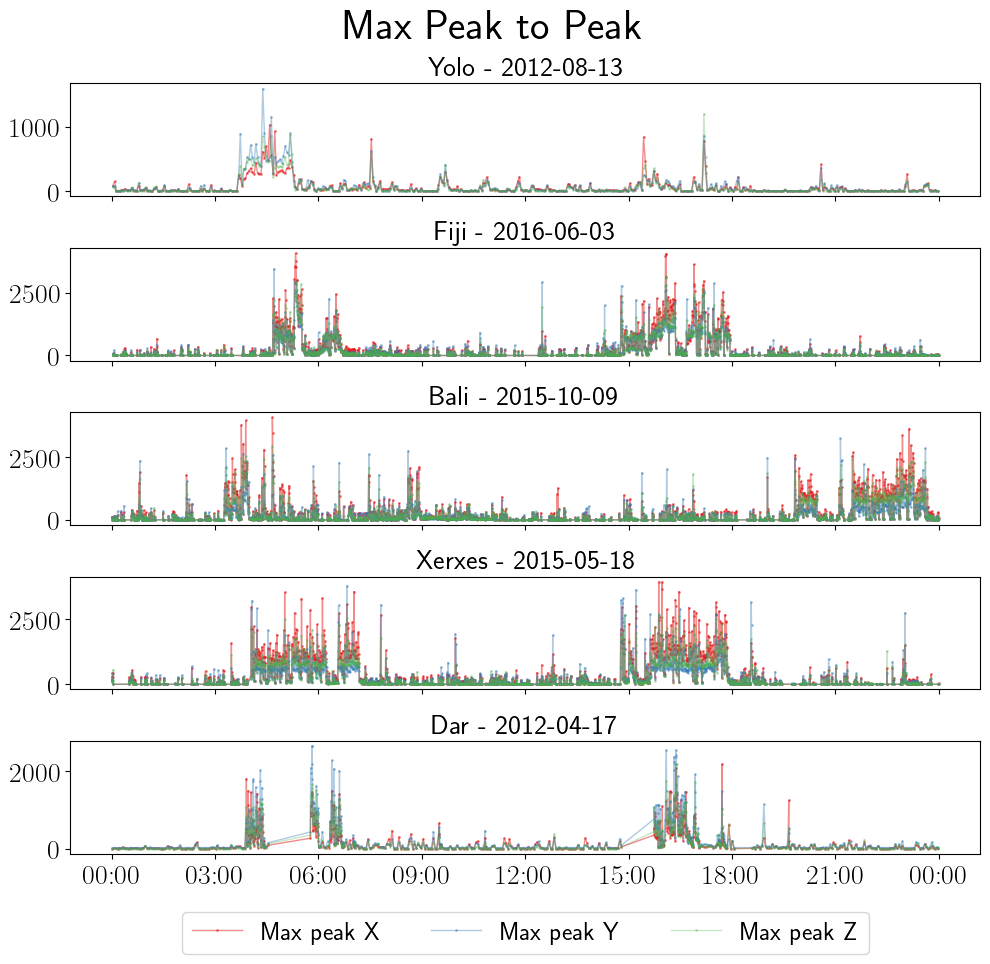

In [16]:
fig, axs = plt.subplots(len(selected_dog_date), 1, figsize=(10,2*len(selected_dog_date)), sharex=True)
palette = sns.color_palette("Set1", n_colors=3)

for i, (dog, date) in enumerate(selected_dog_date.items()):
    date = datetime.strptime(date, "%Y-%m-%d").date()
    df_tmp = historic_data[(historic_data.dog == dog) & (historic_data['UTC time'].dt.date == date)].copy()
    
    # Replace the full datetime with a dummy date and actual time
    df_tmp['time_only'] = df_tmp['UTC time'].apply(lambda x: x.replace(year=1900, month=1, day=1))
    

    loc = AutoDateLocator()
    form = DateFormatter("%H:%M")  # or "%H:%M" if you want hours and minutes only
    axs[i].xaxis.set_major_locator(loc)
    axs[i].xaxis.set_major_formatter(form)  
    axs[i].plot(df_tmp['time_only'], df_tmp['Max peak X'], marker='o', markersize=1, alpha=0.5, linestyle='-', color=palette[0], label='Max peak X')
    axs[i].plot(df_tmp['time_only'], df_tmp['Max peak Y'], marker='o', markersize=1, alpha=0.4, linestyle='-', color=palette[1], label='Max peak Y')
    axs[i].plot(df_tmp['time_only'], df_tmp['Max peak Z'], marker='o', markersize=1, alpha=0.3, linestyle='-', color=palette[2], label='Max peak Z')
    axs[i].set_title(dog + ' - ' + str(date), fontsize=20)
axs[-1].legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -1.))
plt.suptitle(f"Max Peak to Peak", fontsize=30)
plt.tight_layout()
plt.show()

    

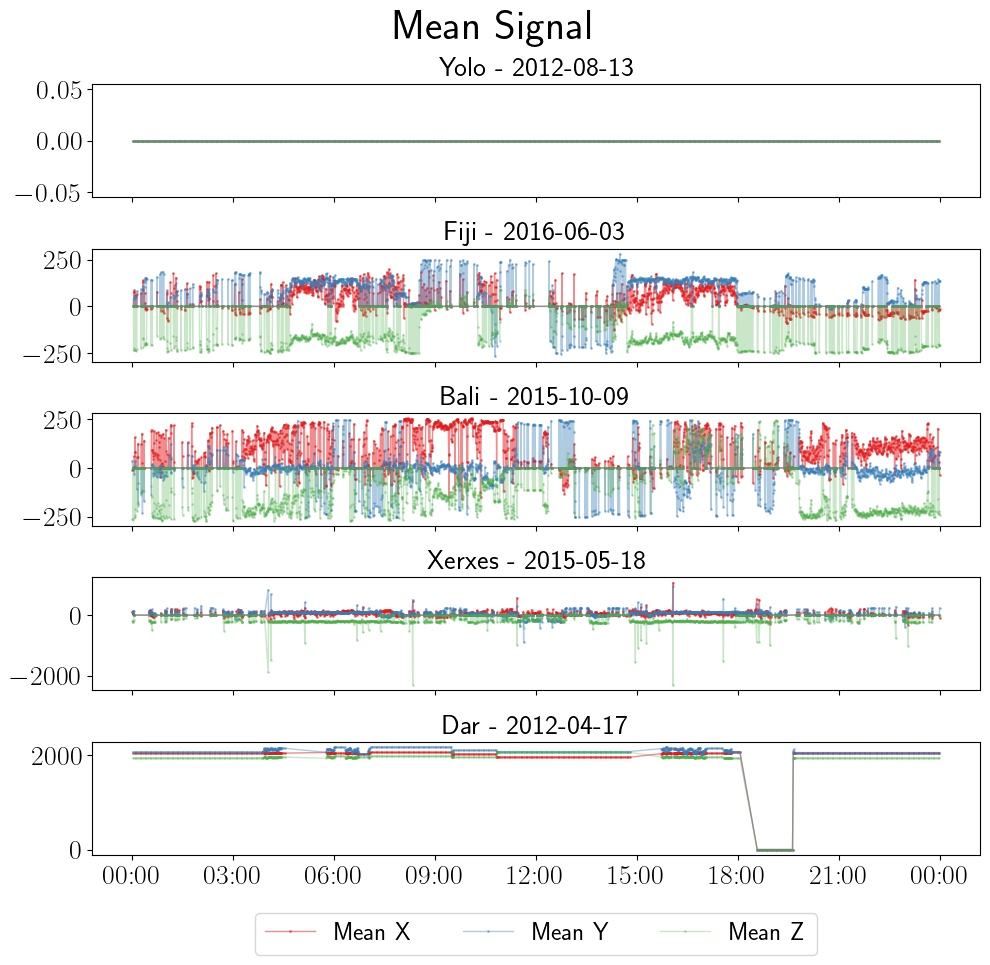

In [17]:
fig, axs = plt.subplots(len(selected_dog_date), 1, figsize=(10,2*len(selected_dog_date)), sharex=True)
palette = sns.color_palette("Set1", n_colors=3)

for i, (dog, date) in enumerate(selected_dog_date.items()):
    date = datetime.strptime(date, "%Y-%m-%d").date()
    df_tmp = historic_data[(historic_data.dog == dog) & (historic_data['UTC time'].dt.date == date)].copy()
    
    # Replace the full datetime with a dummy date and actual time
    df_tmp['time_only'] = df_tmp['UTC time'].apply(lambda x: x.replace(year=1900, month=1, day=1))
    
    loc = AutoDateLocator()
    form = DateFormatter("%H:%M")  # or "%H:%M" if you want hours and minutes only
    axs[i].xaxis.set_major_locator(loc)
    axs[i].xaxis.set_major_formatter(form)  
    axs[i].plot(df_tmp['time_only'], df_tmp['Mean X'], marker='o', markersize=1, alpha=0.5, linestyle='-', color=palette[0], label='Mean X')
    axs[i].plot(df_tmp['time_only'], df_tmp['Mean Y'], marker='o', markersize=1, alpha=0.4, linestyle='-', color=palette[1], label='Mean Y')
    axs[i].plot(df_tmp['time_only'], df_tmp['Mean Z'], marker='o', markersize=1, alpha=0.3, linestyle='-', color=palette[2], label='Mean Z')
    axs[i].set_title(dog + ' - ' + str(date), fontsize=20)
axs[-1].legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -1.))
plt.suptitle(f"Mean Signal", fontsize=30)
plt.tight_layout()
plt.show()


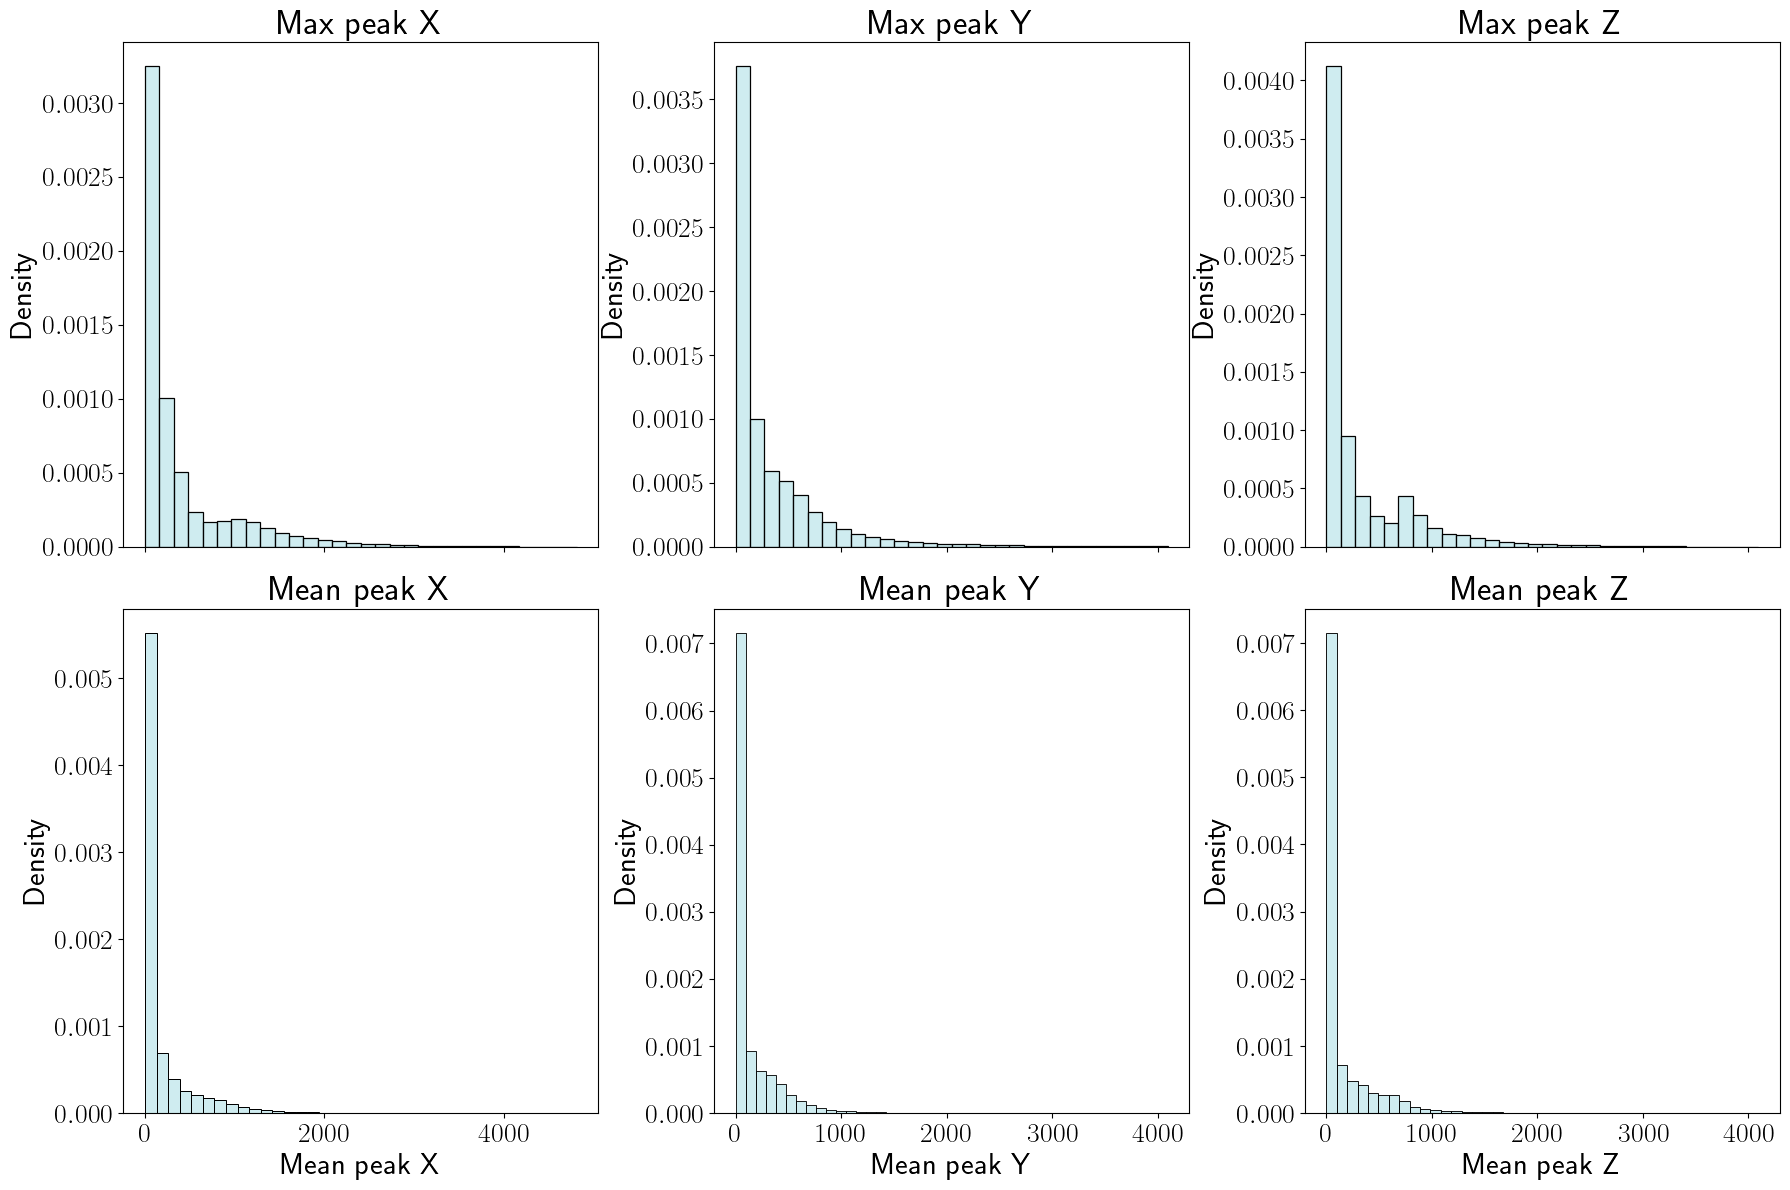

In [36]:
acc_axes = ['X', 'Y', 'Z']
feature_types = ['Max peak', 'Mean peak']

fig, axes = plt.subplots(len(feature_types), len(acc_axes), figsize=(6*len(acc_axes), 6*len(feature_types)), sharey=False, sharex='col')

for i, type in enumerate(feature_types):
    for j, axis in enumerate(acc_axes):

        feature = type + ' ' + axis
        ax = axes[i, j]

        sns.histplot(
                historic_data[feature],
                kde=False,
                ax=ax,
                stat='density',
                bins=30,
                color='powderblue',
                alpha=0.6
            )

        ax.set_title(feature)
        ax.set_xlabel(feature)
        ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

In [41]:
acc_data = pd.read_csv(os.path.join(get_project_root(), 'data', "duration30", "matched_acc_data.csv"))
acc_data['acc_x'] = acc_data['acc_x'].str.strip('[]').apply(lambda x: np.fromstring(x, sep=','))
acc_data['acc_y'] = acc_data['acc_y'].str.strip('[]').apply(lambda x: np.fromstring(x, sep=','))
acc_data['acc_z'] = acc_data['acc_z'].str.strip('[]').apply(lambda x: np.fromstring(x, sep=','))

acc_data_split = create_max_windows(acc_data=acc_data, window_duration=30.0, sampling_rate=SAMPLING_RATE)
acc_data_split = acc_data_split[acc_data_split.duration >= 4.0]
split_acc_data = create_summary_data(acc_data_split, sampling_rate=SAMPLING_RATE)
print(f"Total {np.sum(np.isnan(acc_data_split.acc_x_ptp_max.values))} annotations have duration less than 2 seconds")

vectronics_data = split_acc_data[['acc_x_ptp_max', 'acc_y_ptp_max', 'acc_z_ptp_max',
                                  'acc_x_ptp_mean', 'acc_y_ptp_mean', 'acc_z_ptp_mean',
                                  'acc_x_mean', 'acc_y_mean', 'acc_z_mean',
                                  ]]
                                  
rename_dict = {'acc_x_ptp_max': 'Max peak X', 
               'acc_y_ptp_max': 'Max peak Y', 
               'acc_z_ptp_max': 'Max peak Z',
                'acc_x_ptp_mean': 'Mean peak X', 
                'acc_y_ptp_mean': 'Mean peak Y', 
                'acc_z_ptp_mean': 'Mean peak Z',
                'acc_x_mean': 'Mean X', 
                'acc_y_mean': 'Mean Y',  
                'acc_z_mean': 'Mean Z'}
                
vectronics_data = vectronics_data.rename(columns=rename_dict)

Total 0 annotations have duration less than 2 seconds


## 3. Scaling Methods

#### Min-Max Scaling

In [37]:
features = ['Max peak X', 'Max peak Y', 'Max peak Z',
            'Mean peak X', 'Mean peak Y', 'Mean peak Z',
            # 'Mean mag X', 'Mean mag Y', 'Mean mag Z'
            ]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Transform both datasets to fall between 0 and 1
transformed_a = vectronics_data.copy()
transformed_b = historic_data.copy()

transformed_a[features] = scaler.fit_transform(transformed_a[features])
transformed_b[features] = scaler.fit_transform(transformed_b[features])

df_transformed_a = pd.DataFrame(transformed_a, columns=features)
df_transformed_b = pd.DataFrame(transformed_b, columns=features)

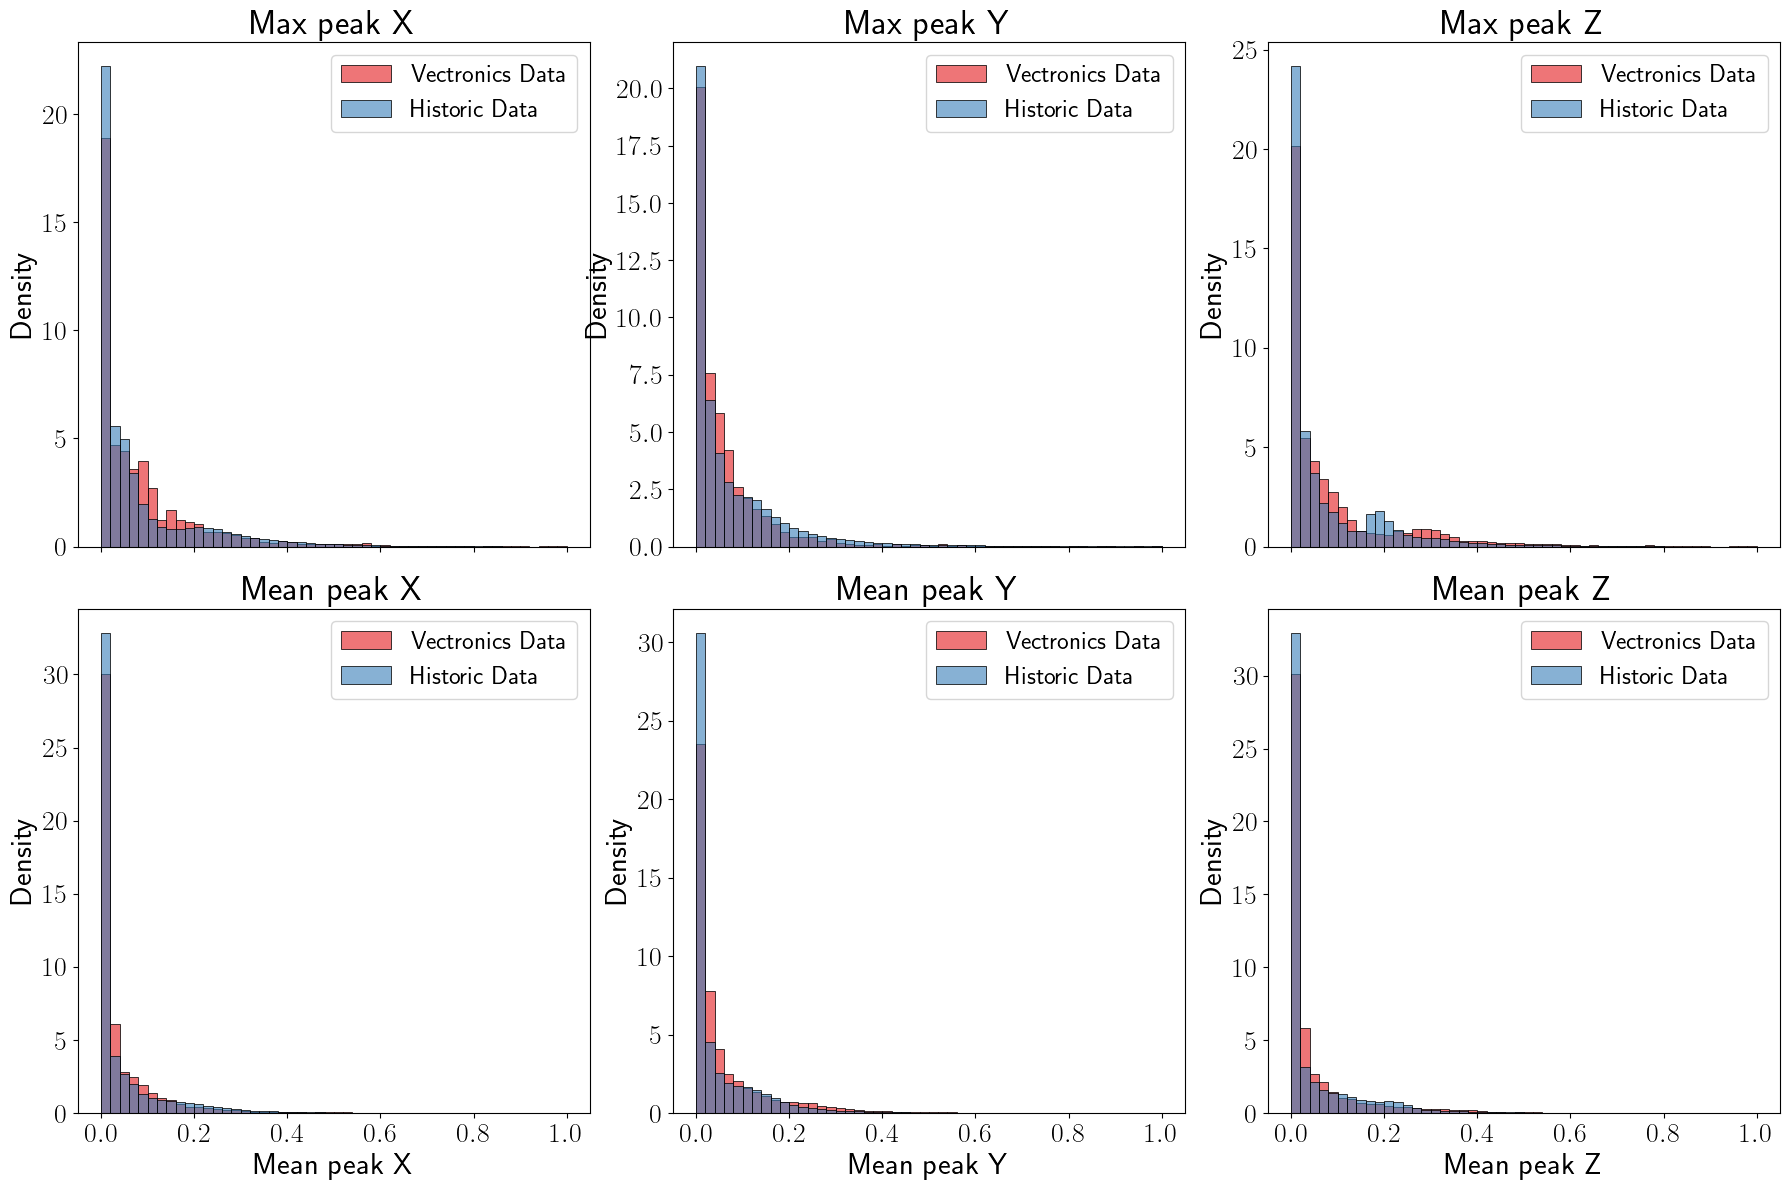

In [43]:
fig, axes = plt.subplots(len(features)//3, 3, figsize=(18, 6*(len(features)//3)), sharey=False, sharex='col')

acc_axes = ['X', 'Y', 'Z']
feature_types = ['Max peak', 'Mean peak']
palette = sns.color_palette("Set1", n_colors=2)

for i, f in enumerate(feature_types):
    for j, axis in enumerate(acc_axes):

        feature = f + ' ' + axis
        ax = axes[i, j]

        sns.histplot(
                df_transformed_a[feature],
                kde=False,
                label='Vectronics Data',
                ax=ax,
                stat='density',
                bins=50,
                color=palette[0],
                alpha=0.6
            )

        sns.histplot(
                df_transformed_b[feature],
                kde=False,
                label='Historic Data',
                ax=ax,
                stat='density',
                bins=50,
                color=palette[1],
                alpha=0.6
            )

        ax.set_title(feature)
        ax.set_xlabel(feature)
        ax.set_ylabel('Density')
        ax.legend()

plt.tight_layout()
plt.show()


In [61]:
Xs = df_transformed_a[features].values
Xt = df_transformed_b[features].values

# shuffle the rows 
np.random.shuffle(Xs)
np.random.shuffle(Xt)

print(f"Number of samples in source data: {Xs.shape[0]}")
print(f"Number of samples in target data: {Xt.shape[0]}")

Number of samples in source data: 14472
Number of samples in target data: 7173771


## 4. Determin Covariate Shift

We compute the sliced Wasserstein distance and Sinkhorn divergence between the two datasets with increasing number of samples $n$ to check if the computed distance decreases as a function of $n$.

In [116]:
import numpy as np
from scipy.spatial.distance import cdist

def sinkhorn_knopp(C, epsilon=0.01, n_iters=1000, tol=1e-9):
    """
    Solve entropy-regularized optimal transport using Sinkhorn algorithm.
    Args:
        C: Cost matrix of shape (n, m)
        epsilon: Entropy regularization coefficient
        n_iters: Max number of Sinkhorn iterations
        tol: Convergence tolerance
    Returns:
        gamma: Optimal transport plan (n x m)
    """
    n, m = C.shape
    K = np.exp(-C / epsilon)

    u = np.ones(n)
    v = np.ones(m)

    # Uniform marginals
    a = np.ones(n) / n
    b = np.ones(m) / m

    for _ in range(n_iters):
        u_prev = u.copy()
        u = a / (K @ v)
        v = b / (K.T @ u)
        # Check convergence (L1 norm)
        if np.linalg.norm(u - u_prev, 1) < tol:
            break

    gamma = np.diag(u) @ K @ np.diag(v)
    return gamma

def entropy_regularized_ot(X, Y, epsilon=0.01, n_iters=1000):
    """
    Compute entropy-regularized OT distance and transported points from X to Y.
    Args:
        X: Source dataset of shape (n, d)
        Y: Target dataset of shape (m, d)
        epsilon: Regularization parameter
    Returns:
        ot_distance: Optimal transport cost
        gamma: Optimal transport plan (n x m)
        transported_X: New position of particles in X pushed toward Y (n x d)
    """
    n, d = X.shape
    m = Y.shape[0]
    
    # Cost matrix: squared Euclidean distance
    C = cdist(X, Y, metric='sqeuclidean')  # shape (n, m)

    # Sinkhorn to get transport plan
    gamma = sinkhorn_knopp(C, epsilon, n_iters)

    # OT distance = <gamma, C>
    ot_distance = np.sum(gamma * C)

    # Transported positions: push source particles toward target barycenter
    transported_X = gamma @ Y  # shape (n, d)
    row_sums = gamma.sum(axis=1, keepdims=True)
    transported_X = transported_X / row_sums


    return ot_distance, gamma, transported_X


In [127]:
n_list = 1000 * np.arange(1, 11)

swd_list = []
for n in tqdm(n_list):
    swd = sliced_wasserstein_distance(Xs[:n,:], Xt[:n,:], num_directions=100)
    swd_list.append(swd)

dist_list = []
for n in tqdm(n_list):
    Xs_sample = Xs[:n,:]
    Ys_sample = Xt[:n,:]
    dist, _, aligned = entropy_regularized_ot(Xs_sample, Ys_sample, epsilon=0.01, n_iters=1000)
    dist_list.append(dist)

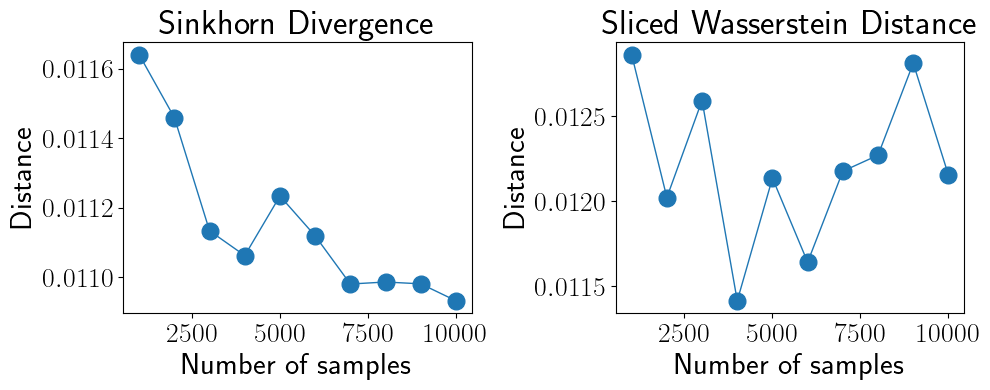

In [128]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(n_list, dist_list, marker='o')
axs[0].set_xlabel('Number of samples')
axs[0].set_ylabel('Distance')
axs[0].set_title('Sinkhorn Divergence')

axs[1].plot(n_list, swd_list, marker='o')
axs[1].set_xlabel('Number of samples')
axs[1].set_ylabel('Distance')
axs[1].set_title('Sliced Wasserstein Distance')
plt.tight_layout()
plt.show()


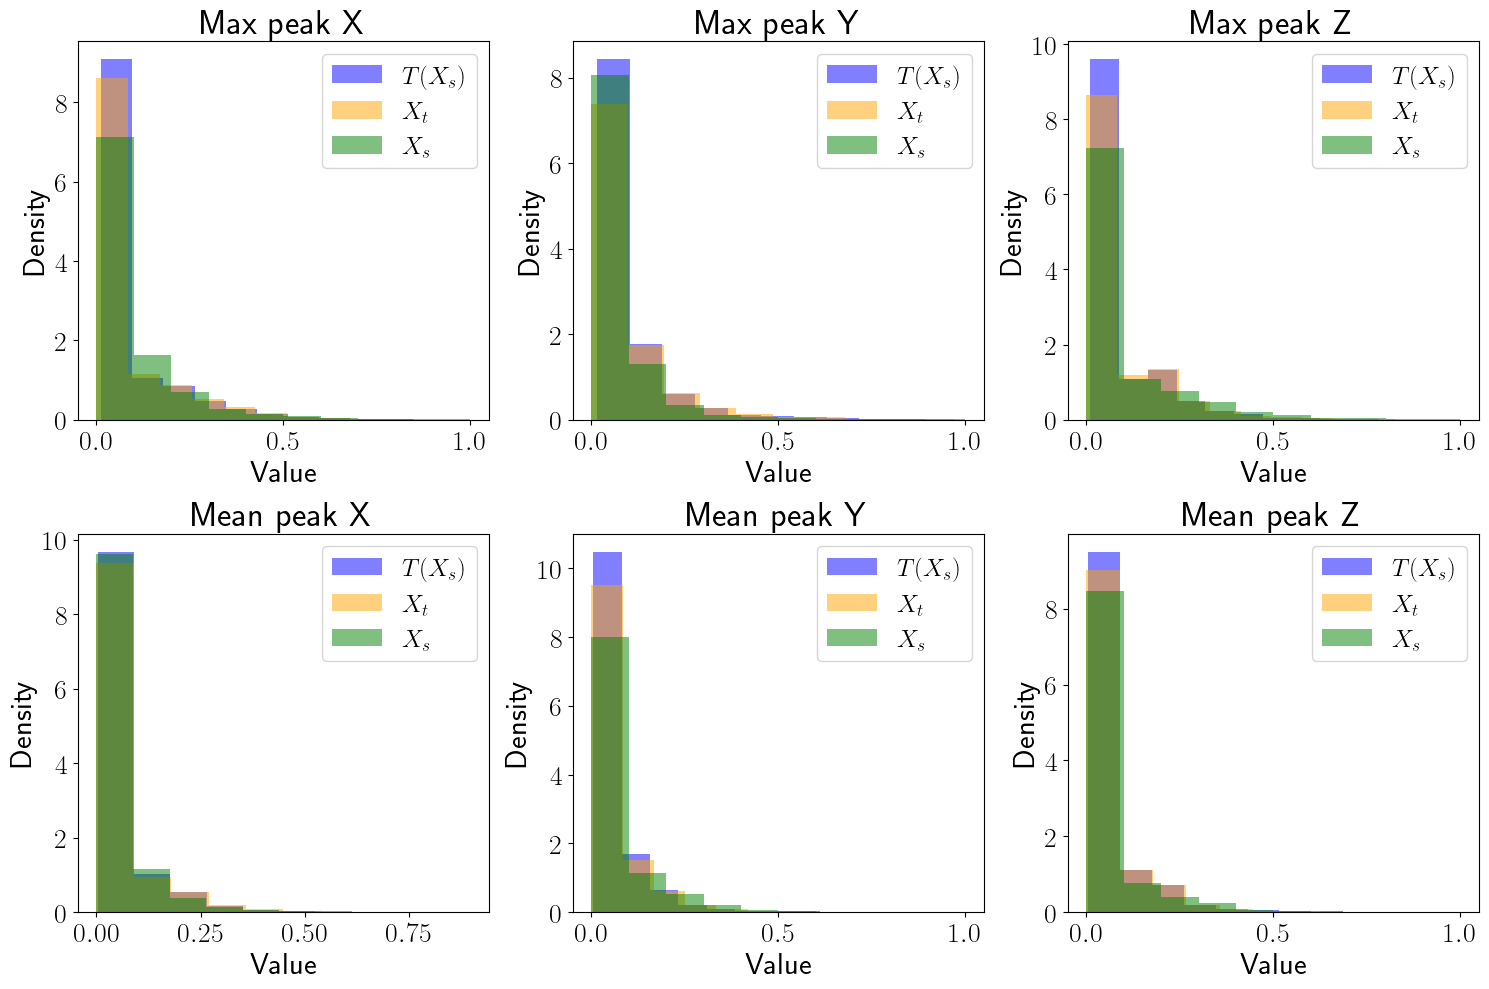

In [129]:
fig, axs = plt.subplots(len(features)//3, 3, figsize=(15, 5*len(features)//3))
n = len(aligned)
for i, ax in enumerate(axs.flat):
    ax.hist(aligned[:, i], alpha=0.5, label=r'$T(X_s)$', color='blue', density=True)
    ax.hist(Xt[:n, i], alpha=0.5, label=r'$X_t$', color='orange', density=True)
    ax.hist(Xs[:n, i], alpha=0.5, label=r'$X_s$', color='green', density=True)

    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.set_title(features[i])
    ax.legend()

plt.tight_layout()
plt.show()

In [130]:
from scipy.spatial.distance import cdist

def rbf_kernel(X, Y, sigma=1.0):
    """Compute the RBF (Gaussian) kernel between two sets of vectors."""
    dists = cdist(X, Y, 'sqeuclidean')
    return np.exp(-dists / (2 * sigma ** 2))

def compute_mmd(X, Y, sigma=1.0):
    """Biased estimator of MMD², guaranteed to be ≥ 0."""
    K_XX = rbf_kernel(X, X, sigma)
    K_YY = rbf_kernel(Y, Y, sigma)
    K_XY = rbf_kernel(X, Y, sigma)

    mmd2 = K_XX.mean() + K_YY.mean() - 2 * K_XY.mean()
    return mmd2

def mmd_test(X, Y, sigma=1.0, num_permutations=1000, seed=None):
    """Two-sample test using MMD with permutation test to get p-value."""
    rng = np.random.default_rng(seed)
    n, m = len(X), len(Y)
    Z = np.vstack([X, Y])
    observed_mmd = compute_mmd(X, Y, sigma=sigma)

    permuted_mmds = []
    for _ in range(num_permutations):
        idx = rng.permutation(n + m)
        X_perm = Z[idx[:n]]
        Y_perm = Z[idx[n:]]
        permuted_mmds.append(compute_mmd(X_perm, Y_perm, sigma=sigma))

    p_value = np.mean([mmd >= observed_mmd for mmd in permuted_mmds])
    return observed_mmd, permuted_mmds, p_value


In [131]:
def median_pairwise_distance(X, Y):
    Z = np.vstack([X, Y])
    dists = cdist(Z, Z, 'euclidean')
    return np.median(dists[np.triu_indices_from(dists, k=1)])

n, m = 2000, 2000
sigma = median_pairwise_distance(Xs[:n, :], Xt[:m, :])
stat, permuted_stat, pval = mmd_test(X=Xs[:n, :], Y=Xt[:m, :], sigma=sigma, num_permutations=1000, seed=42)

print(f"MMD^2 statistic: {stat:.4f}")
if pval < 0.05:
    print(f"P-value: {pval:.4f} - The two distributions are significantly different (reject H0).")
else:
    print(f"P-value: {pval:.4f} - The two distributions are not significantly different (fail to reject H0).")

MMD^2 statistic: 0.0122
P-value: 0.0000 - The two distributions are significantly different (reject H0).
